## Setup

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import json

from tests.eas.load_tracking import FreqInvarianceTest
from trace import Trace
from trappy.plotter import plot_trace
from trappy.stats.grammar import Parser
from trappy import ILinePlot

In [3]:
import logging
from conf import LisaLogging
LisaLogging.setup()
logging.getLogger('Analysis').setLevel(logging.ERROR)

2016-11-29 18:57:20,727 INFO    : root         : Using LISA logging configuration:
2016-11-29 18:57:20,728 INFO    : root         :   /home/brejac01/sources/lisa/logging.conf


## Run test workload

In [4]:
t = FreqInvarianceTest(methodName='test_task_util')

In [5]:
t.setUpClass()

2016-11-29 18:57:20,744 INFO    : LisaTest     : Setup tests execution engine...
2016-11-29 18:57:20,745 INFO    : TestEnv      : Using base path: /home/brejac01/sources/lisa
2016-11-29 18:57:20,745 INFO    : TestEnv      : Loading default (file) target configuration
2016-11-29 18:57:20,746 INFO    : TestEnv      : Loading target configuration [/home/brejac01/sources/lisa/target.config]...
2016-11-29 18:57:20,750 INFO    : TestEnv      : Loading custom (inline) test configuration
2016-11-29 18:57:20,751 INFO    : TestEnv      : Devlib modules to load: ['bl', u'cpuidle', 'cpufreq']
2016-11-29 18:57:20,752 INFO    : TestEnv      : Connecting linux target:
2016-11-29 18:57:20,753 INFO    : TestEnv      :   username : brendan
2016-11-29 18:57:20,753 INFO    : TestEnv      :       host : 192.168.2.2
2016-11-29 18:57:20,754 INFO    : TestEnv      :   password : password
2016-11-29 18:57:20,755 INFO    : TestEnv      : Connection settings:
2016-11-29 18:57:20,756 INFO    : TestEnv      :    {

ON CPU 1


2016-11-29 18:57:41,019 INFO    : Executor     : Configuring all CPUs to use [userspace] cpufreq governor
2016-11-29 18:57:41,924 INFO    : root         :        CPUFreq - CPU frequencies: {1: 450000}
2016-11-29 18:57:43,946 INFO    : Workload     : Setup new workload fie_10pct
2016-11-29 18:57:43,947 INFO    : Workload     : Workload duration defined by longest task
2016-11-29 18:57:43,948 INFO    : Workload     : Default policy: SCHED_OTHER
2016-11-29 18:57:43,949 INFO    : Workload     : ------------------------
2016-11-29 18:57:43,950 INFO    : Workload     : task [fie_test0], sched: using default policy
2016-11-29 18:57:43,951 INFO    : Workload     :  | calibration CPU: 1
2016-11-29 18:57:43,953 INFO    : Workload     :  | loops count: 1
2016-11-29 18:57:43,954 INFO    : Workload     : + phase_000001: duration 5.000000 [s] (500 loops)
2016-11-29 18:57:43,955 INFO    : Workload     : |  period    10000 [us], duty_cycle  10 %
2016-11-29 18:57:43,956 INFO    : Workload     : |  run_

2016-11-29 18:58:03,817 INFO    : Executor     : Collected FTrace binary trace:
2016-11-29 18:58:03,819 INFO    : Executor     :    <res_dir>/rtapp:freq_450000:fie_10pct/1/trace.dat
2016-11-29 18:58:03,820 INFO    : Executor     : Collected FTrace function profiling:
2016-11-29 18:58:03,821 INFO    : Executor     :    <res_dir>/rtapp:freq_450000:fie_10pct/1/trace_stat.json
2016-11-29 18:58:03,822 INFO    : Executor     : --------------------------------------------------------------------------------
2016-11-29 18:58:03,823 INFO    : Executor     : 
2016-11-29 18:58:03,824 INFO    : Executor     : ================================================================================
2016-11-29 18:58:03,825 INFO    : Executor     : configuring target for [freq_625000] experiments
2016-11-29 18:58:05,547 INFO    : Executor     : Configuring all CPUs to use [userspace] cpufreq governor
2016-11-29 18:58:06,454 INFO    : root         :        CPUFreq - CPU frequencies: {1: 625000}
2016-11-29 18:5

2016-11-29 18:58:27,413 INFO    : Executor     : Collected FTrace binary trace:
2016-11-29 18:58:27,415 INFO    : Executor     :    <res_dir>/rtapp:freq_625000:fie_10pct/1/trace.dat
2016-11-29 18:58:27,416 INFO    : Executor     : Collected FTrace function profiling:
2016-11-29 18:58:27,417 INFO    : Executor     :    <res_dir>/rtapp:freq_625000:fie_10pct/1/trace_stat.json
2016-11-29 18:58:27,418 INFO    : Executor     : --------------------------------------------------------------------------------
2016-11-29 18:58:27,420 INFO    : Executor     : 
2016-11-29 18:58:27,421 INFO    : Executor     : ================================================================================
2016-11-29 18:58:27,422 INFO    : Executor     : configuring target for [freq_800000] experiments
2016-11-29 18:58:29,142 INFO    : Executor     : Configuring all CPUs to use [userspace] cpufreq governor
2016-11-29 18:58:30,048 INFO    : root         :        CPUFreq - CPU frequencies: {1: 800000}
2016-11-29 18:5

2016-11-29 18:58:50,578 INFO    : Executor     : Collected FTrace binary trace:
2016-11-29 18:58:50,580 INFO    : Executor     :    <res_dir>/rtapp:freq_800000:fie_10pct/1/trace.dat
2016-11-29 18:58:50,582 INFO    : Executor     : Collected FTrace function profiling:
2016-11-29 18:58:50,583 INFO    : Executor     :    <res_dir>/rtapp:freq_800000:fie_10pct/1/trace_stat.json
2016-11-29 18:58:50,584 INFO    : Executor     : --------------------------------------------------------------------------------
2016-11-29 18:58:50,585 INFO    : Executor     : 
2016-11-29 18:58:50,586 INFO    : Executor     : ================================================================================
2016-11-29 18:58:50,587 INFO    : Executor     : configuring target for [freq_950000] experiments
2016-11-29 18:58:52,306 INFO    : Executor     : Configuring all CPUs to use [userspace] cpufreq governor
2016-11-29 18:58:53,212 INFO    : root         :        CPUFreq - CPU frequencies: {1: 950000}
2016-11-29 18:5

2016-11-29 18:59:13,508 INFO    : Executor     : Collected FTrace binary trace:
2016-11-29 18:59:13,510 INFO    : Executor     :    <res_dir>/rtapp:freq_950000:fie_10pct/1/trace.dat
2016-11-29 18:59:13,511 INFO    : Executor     : Collected FTrace function profiling:
2016-11-29 18:59:13,513 INFO    : Executor     :    <res_dir>/rtapp:freq_950000:fie_10pct/1/trace_stat.json
2016-11-29 18:59:13,514 INFO    : Executor     : --------------------------------------------------------------------------------
2016-11-29 18:59:13,515 INFO    : Executor     : 
2016-11-29 18:59:13,516 INFO    : Executor     : ================================================================================
2016-11-29 18:59:13,517 INFO    : Executor     : configuring target for [freq_1100000] experiments
2016-11-29 18:59:15,234 INFO    : Executor     : Configuring all CPUs to use [userspace] cpufreq governor
2016-11-29 18:59:16,140 INFO    : root         :        CPUFreq - CPU frequencies: {1: 1100000}
2016-11-29 18

2016-11-29 18:59:39,530 INFO    : Executor     : Collected FTrace binary trace:
2016-11-29 18:59:39,532 INFO    : Executor     :    <res_dir>/rtapp:freq_1100000:fie_10pct/1/trace.dat
2016-11-29 18:59:39,533 INFO    : Executor     : Collected FTrace function profiling:
2016-11-29 18:59:39,534 INFO    : Executor     :    <res_dir>/rtapp:freq_1100000:fie_10pct/1/trace_stat.json
2016-11-29 18:59:39,535 INFO    : Executor     : --------------------------------------------------------------------------------
2016-11-29 18:59:39,535 INFO    : Executor     : 
2016-11-29 18:59:39,536 INFO    : Executor     : ################################################################################
2016-11-29 18:59:39,537 INFO    : Executor     : Experiments execution completed
2016-11-29 18:59:39,538 INFO    : Executor     : ################################################################################
2016-11-29 18:59:39,538 INFO    : Executor     : Results available in:
2016-11-29 18:59:39,539 INFO  

## Show variance in util_avg and load_avg

In [6]:
# Get the frequency an experiment was run at
def experiment_freq(exp):
    [cpu] = exp.wload.cpus
    freq = exp.conf['cpufreq']['freqs'][cpu]
    return freq
freqs = [experiment_freq(e) for e in t.executor.experiments]
freqs

[450000, 625000, 800000, 950000, 1100000]

In [7]:
def plot_signal_against_freq(signal):
    means = [t.get_signal_mean(e, signal) for e in t.executor.experiments]
    limits = (min(means) * 0.99, max(means) * 1.01)
    pd.DataFrame(means, index=freqs, columns=['Mean ' + signal]).plot(kind='bar', ylim=limits)

### Plot of variation of util_avg value with frequency:

2016-11-29 18:59:39,570 INFO    : Trace        : Parsing FTrace format...
2016-11-29 18:59:40,347 INFO    : Trace        : Collected events spans a 9.952 [s] time interval
2016-11-29 18:59:40,348 INFO    : Trace        : Set plots time range to (0.000000, 9.952366)[s]
2016-11-29 18:59:40,480 INFO    : Trace        : Parsing FTrace format...
2016-11-29 18:59:40,839 INFO    : Trace        : Collected events spans a 9.952 [s] time interval
2016-11-29 18:59:40,841 INFO    : Trace        : Set plots time range to (0.000000, 9.952366)[s]
2016-11-29 18:59:40,898 INFO    : Trace        : Parsing FTrace format...
2016-11-29 18:59:41,552 INFO    : Trace        : Collected events spans a 9.911 [s] time interval
2016-11-29 18:59:41,553 INFO    : Trace        : Set plots time range to (0.000000, 9.910778)[s]
2016-11-29 18:59:41,658 INFO    : Trace        : Parsing FTrace format...
2016-11-29 18:59:41,975 INFO    : Trace        : Collected events spans a 9.911 [s] time interval
2016-11-29 18:59:41,9

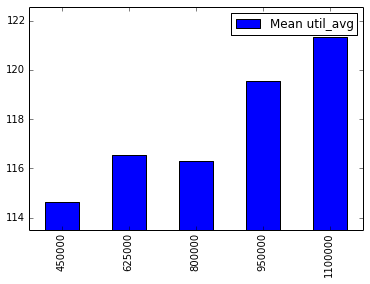

In [8]:
plot_signal_against_freq('util_avg')

### And the same thing for load_avg:

2016-11-29 18:59:45,704 INFO    : Trace        : Parsing FTrace format...
2016-11-29 18:59:46,028 INFO    : Trace        : Collected events spans a 9.952 [s] time interval
2016-11-29 18:59:46,029 INFO    : Trace        : Set plots time range to (0.000000, 9.952366)[s]
2016-11-29 18:59:46,090 INFO    : Trace        : Parsing FTrace format...
2016-11-29 18:59:46,409 INFO    : Trace        : Collected events spans a 9.911 [s] time interval
2016-11-29 18:59:46,410 INFO    : Trace        : Set plots time range to (0.000000, 9.910778)[s]
2016-11-29 18:59:46,462 INFO    : Trace        : Parsing FTrace format...
2016-11-29 18:59:46,790 INFO    : Trace        : Collected events spans a 9.843 [s] time interval
2016-11-29 18:59:46,791 INFO    : Trace        : Set plots time range to (0.000000, 9.843372)[s]
2016-11-29 18:59:46,850 INFO    : Trace        : Parsing FTrace format...
2016-11-29 18:59:47,162 INFO    : Trace        : Collected events spans a 9.805 [s] time interval
2016-11-29 18:59:47,1

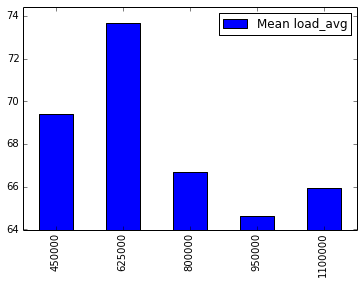

In [9]:
plot_signal_against_freq('load_avg')

## Examine trace from workload execution

The log `setUpClass` call above shows the experiments that were run. Use the function below to get a plot from a given experiment of the `util_avg` scheduler signal for that workload's tasks, along with the expected mean value.

In [10]:
def examine_experiment(idx, signal):
    experiment = t.executor.experiments[idx]
    
    print "Experiment configuration:" 
    print json.dumps(experiment.conf, indent=4)
    events = t.te.test_conf["ftrace"]["events"]
    
    # todo add get_trace method
    tasks = experiment.wload.tasks.keys()
    #trace = Trace(t.te.platform, experiment.out_dir, events, tasks)
    #print "Trace plot:"
    #plot_trace(trace.ftrace)
    
    # Get observed signal
    signal_df = t.get_sched_signal(experiment, signal)
#    return signal_df
    # Get expected average value for util_avg signal
    expected_util_avg_mean = t.get_expected_util_avg(experiment)
    
    # Plot util avg signal with expected mean value
    util_avg_mean = pd.Series([expected_util_avg_mean], name="expected_util_avg", index=[signal_df.index[0]])
    df = pd.concat([signal_df, util_avg_mean], axis=1).fillna(method="ffill")
    ILinePlot(df, column=[signal, "expected_util_avg"], drawstyle="steps-post").view()

In [11]:
plot_trace(t.get_trace(t.executor.experiments[0]).ftrace)

2016-11-29 18:59:47,693 INFO    : Trace        : Parsing FTrace format...
2016-11-29 18:59:48,011 INFO    : Trace        : Collected events spans a 9.952 [s] time interval
2016-11-29 18:59:48,012 INFO    : Trace        : Set plots time range to (0.000000, 9.952366)[s]


In [12]:
df = examine_experiment(-1, "util_avg")

2016-11-29 18:59:48,366 INFO    : Trace        : Parsing FTrace format...


Experiment configuration:
{
    "dtb": null, 
    "kernel": null, 
    "tag": "freq_1100000", 
    "flags": "ftrace", 
    "cpufreq": {
        "freqs": {
            "1": 1100000
        }, 
        "governor": "userspace"
    }
}


2016-11-29 18:59:48,685 INFO    : Trace        : Collected events spans a 9.777 [s] time interval
2016-11-29 18:59:48,686 INFO    : Trace        : Set plots time range to (0.000000, 9.777191)[s]


""
""


In [13]:
df = examine_experiment(-1, "load_avg")

2016-11-29 18:59:48,751 INFO    : Trace        : Parsing FTrace format...


Experiment configuration:
{
    "dtb": null, 
    "kernel": null, 
    "tag": "freq_1100000", 
    "flags": "ftrace", 
    "cpufreq": {
        "freqs": {
            "1": 1100000
        }, 
        "governor": "userspace"
    }
}


2016-11-29 18:59:49,079 INFO    : Trace        : Collected events spans a 9.777 [s] time interval
2016-11-29 18:59:49,080 INFO    : Trace        : Set plots time range to (0.000000, 9.777191)[s]


""
""
